In [2]:
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# let's make some data

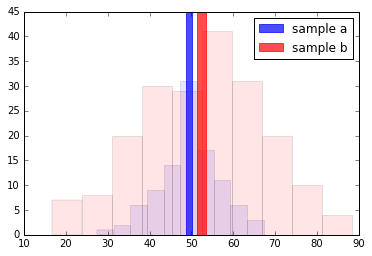

In [37]:
a = np.random.normal(50.,7.4,size=100)
b = np.random.normal(53.5,15.9,size=200)
fig,ax = plt.subplots()
ax.hist(a,color='blue',alpha=0.1)
ax.hist(b,color='red',alpha=0.1)
ax.axvspan(a.mean()-a.std()/np.sqrt(a.size),a.mean()+a.std()/np.sqrt(a.size),color='blue',alpha=0.7,label='sample a')
ax.axvspan(b.mean()-b.std()/np.sqrt(b.size),b.mean()+b.std()/np.sqrt(b.size),color='red', alpha=0.7,label='sample b')
ax.legend()

## parametric independent t test with equal variance assumption

In [38]:
stats.ttest_ind(a,b,equal_var=True,)

Ttest_indResult(statistic=-1.9268281984810618, pvalue=0.054951711126329676)

## parametric independent t test without equal variance assumption

In [39]:
stats.ttest_ind(a,b,equal_var=False,)

Ttest_indResult(statistic=-2.3789275597396289, pvalue=0.017993397773308446)

## nonparametric t test using scipy

In [41]:
stats.mannwhitneyu(a,b,)

MannwhitneyuResult(statistic=8408.0, pvalue=0.012320683494319057)

## nonparametric t test by permutation test

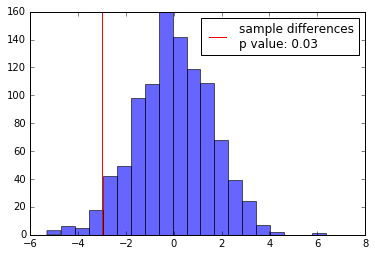

In [54]:
fig, ax = plt.subplots()
difference = np.mean(a) - np.mean(b)
results=[]
for ii in range(1000):
    c = np.concatenate([a,b])
    random.shuffle(c)
    new_a = c[:100]
    new_b = c[100:]
    new_diff = new_a.mean() - new_b.mean()
    results.append(new_diff)
results = np.array(results)
ax.hist(results,color='blue',alpha=0.6,bins=20)
p = min([stats.percentileofscore(results,difference,)/100,1-stats.percentileofscore(results,difference,)/100])
ax.axvline(difference,color='red',label='sample differences\np value: %.2f'%p)
ax.legend()

## redo the permutation test multiple times and sample the distribution of the p values

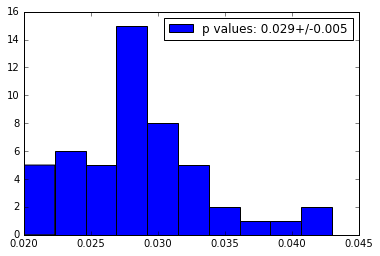

In [57]:
results = []
for ii in range(50):
    temp=[]
    for jj in range(1000):
        c = np.concatenate([a,b])
        random.shuffle(c)
        new_a = c[:100]
        new_b = c[100:]
        new_diff = new_a.mean() - new_b.mean()
        temp.append(new_diff)
    temp = np.array(temp)
    p=min([stats.percentileofscore(temp,difference,)/100,1-stats.percentileofscore(temp,difference,)/100])
    results.append(p)
fig, ax = plt.subplots()
ax.hist(results,bins=10,label='p values: %.3f+/-%.3f'%(np.mean(results),np.std(results)))
ax.legend(loc='best')

# Bayesian stats

In [58]:
import pymc3 as pm

In [59]:
c = np.concatenate([a,b])
c_m = c.mean()
c_s = c.std()*2
with pm.Model() as model:
    a_mean = pm.Normal('a_mean',c_m,sd=c_s)
    b_mean = pm.Normal('b_mean',c_m,sd=c_s)

In [60]:
sigma_low = 1
sigma_high = 15
with model:
    a_std = pm.Uniform('a_std',lower=sigma_low,
                       upper=sigma_high)
    b_std = pm.Uniform('b_std',lower=sigma_low,
                       upper=sigma_high)

In [61]:
with model:
    v = pm.Exponential('v_minus_one',1/29.) +1

In [62]:
with model:
    lambda1=a_std**-2
    lambda2=b_std**-2
    
    aa = pm.StudentT('a',nu=v,mu=a_mean,lam=lambda1,
                    observed=a,)
    bb = pm.StudentT('b',nu=b_mean,lam=lambda2,
                    observed=b)

c:\Anaconda3\lib\site-packages\pymc3\distributions\continuous.py:62: UserWarning: The variable specified for nu has negative support for StudentT, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [63]:
with model:
    diff_of_means = pm.Deterministic('difference of means',
                                    a_mean-b_mean)
    diff_of_stds = pm.Deterministic('difference of stds',
                                   a_std-b_std)
    effect_size = pm.Deterministic('effect size',
                                  diff_of_means/np.sqrt((a_std**2+b_std**2)/2))

In [ ]:
with model:
    trace = pm.sample(2000,init=None)